In [100]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import math
import sys
import os

In [101]:
# See: https://github.com/totex/PyOpenGL_tutorials/blob/master/ObjLoader.py
class ObjLoader:
    def __init__(self):
        self.vert_coords = []
        self.text_coords = []
        self.norm_coords = []
        self.vert_colors = []

        self.vertex_index = []
        self.texture_index = []
        self.normal_index = []

        self.materials = {}

        self.object = None
        self.mtllib = None
        self.usemtl = None
        self.smooth = None

    def load_material(self, file):
        matname = os.path.splitext(os.path.basename(file))[0]
        matdata = None

        class Material:
            def __init__(self, path):
                self.path = path
                self.Ns = None
                self.Ni = None
                self.Ka = None
                self.Kd = None
                self.Ks = None
                self.Ke = None
                self.d = None
                self.illum = None
                self.map_Kd = None
            def __repr__(self):
                return f"Material['{self.map_Kd}']"
            def __str__(self):
                return f"Material['{self.map_Kd}']"
            def getKdImage(self):
                return Image.open(os.path.join(os.path.dirname(self.path), self.map_Kd))

        for line in open(file, 'r'):
            if line.lstrip().startswith('#'): continue
            values = line.split()
            if not values: continue

            if values[0] == 'newmtl':
                matname = values[1]
                matdata = Material(file)
            if values[0] == 'Ns':
                matdata.Ns = values[1]
            if values[0] == 'Ni':
                matdata.Ni = values[1]
            if values[0] == 'Ka':
                matdata.Ka = values[1:4]
            if values[0] == 'Kd':
                matdata.Kd = values[1:4]
            if values[0] == 'Ks':
                matdata.Ks = values[1:4]
            if values[0] == 'Ke':
                matdata.Ke = values[1:4]
            if values[0] == 'd':
                matdata.d = values[1]
            if values[0] == 'illum':
                matdata.illum = values[1]
            if values[0] == 'map_Kd':
                matdata.map_Kd = values[1]

        self.materials[matname] = matdata

    def load_model(self, file):
        normals = False
        texture = False
        vcolors = False
        for line in open(file, 'r'):
            if line.lstrip().startswith('#'): continue
            values = line.split()
            if not values: continue

            if values[0] == 'o':
                self.object = values[1]

            if values[0] == 's':
                self.smooth = values[1]

            if values[0] == 'mtllib':
                self.mtllib = values[1]

                mtllib = os.path.join(os.path.dirname(file), values[1])
                self.load_material(mtllib)

            if values[0] == 'usemtl':
                self.usemtl = values[1]

                self.material = self.materials[values[1]]

            if values[0] == 'v':
                self.vert_coords.append([float(v) for v in values[1:4]])
                if len(values) >= 7:
                    vcolors = True
                    self.vert_colors.append(values[4:7])
            if values[0] == 'vt':
                texture = True
                self.text_coords.append([float(v) for v in values[1:3]])
            if values[0] == 'vn':
                normals = True
                self.norm_coords.append([float(v) for v in values[1:4]])

            if values[0] == 'f':
                face_i = []
                text_i = []
                norm_i = []
                for v in values[1:]:
                    w = v.split('/')
                    face_i.append(int(w[0])-1)
                    if texture:
                        text_i.append(int(w[1])-1)
                    if normals:
                        norm_i.append(int(w[2])-1)
                self.vertex_index.append([face_i])
                if texture:
                    self.texture_index.append([text_i])
                if normals:
                    self.normal_index.append([norm_i])

        self.vertex_index = [y for x in self.vertex_index for y in x]
        self.texture_index = [y for x in self.texture_index for y in x]
        self.normal_index = [y for x in self.normal_index for y in x]

        if texture:
            assert(len(self.vertex_index) == len(self.texture_index))
        if normals:
            assert(len(self.vertex_index) == len(self.normal_index))

    def calc_boundaries(self):
        min_x = float('inf')
        min_y = float('inf')
        min_z = float('inf')

        max_x = float('-inf')
        max_y = float('-inf')
        max_z = float('-inf')

        for x, y, z in self.vert_coords:
            min_x = min(min_x, float(x))
            min_y = min(min_y, float(y))
            min_z = min(min_z, float(z))

            max_x = max(max_x, float(x))
            max_y = max(max_y, float(y))
            max_z = max(max_z, float(z))

        return (min_x, min_y, min_z), (max_x, max_y, max_z)

    def print_model(self, file=sys.stderr):
        def w(*args, **kwargs):
            print(*args, file=file, **kwargs)

        if not self.mtllib is None:
            w(f"mtllib {self.mtllib}")
        if not self.object is None:
            w(f"o {self.object}")
        for v in self.vert_coords:
            w("v " + ' '.join([f"{n:.6f}" for n in v]))
        for vt in self.text_coords:
            w("vt " + ' '.join([f"{n:.4f}" for n in vt]))
        for vn in self.norm_coords:
            w("vn " + ' '.join([f"{n:.4f}" for n in vn]))
        if not self.usemtl is None:
            w(f"usemtl {self.usemtl}")
        if not self.smooth is None:
            w(f"s {self.smooth}")
        for vl, tl, nl in zip(self.vertex_index, self.texture_index, self.normal_index):
            w("f " + ' '.join([f"{vi+1}/{ti+1}/{ni+1}" for vi, ti, ni in zip(vl, tl, nl)]))



vert_coords (8)   = [[1.0, 0.0, 0.0], [1.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, 0.0], [1.0, 2.0, 0.0], [1.0, 2.0, 1.0], [0.0, 2.0, 1.0], [0.0, 2.0, 0.0]]
text_coords (20)   = [[0.0, 0.0], [0.0, 1.0], [1.0, 1.0], [1.0, 0.0], [0.0, 0.0], [0.0, 1.0], [1.0, 1.0], [1.0, 0.0], [0.0, 1.0], [1.0, 1.0], [1.0, 0.0], [0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [0.0, 0.0], [0.0, 1.0], [1.0, 1.0], [0.0, 1.0], [1.0, 1.0], [1.0, 0.0]]
norm_coords (6)   = [[0.0, -1.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [-0.0, -0.0, 1.0], [-1.0, -0.0, -0.0], [0.0, 0.0, -1.0]]
vert_colors (0)   = []
vertex_index (6)  = [[0, 1, 2, 3], [4, 7, 6, 5], [0, 4, 5, 1], [1, 5, 6, 2], [2, 6, 7, 3], [4, 0, 3, 7]]
texture_index (6) = [[0, 1, 2, 3], [4, 5, 6, 7], [0, 8, 9, 10], [11, 12, 6, 13], [14, 15, 16, 3], [4, 17, 18, 19]]
normal_index (6)  = [[0, 0, 0, 0], [1, 1, 1, 1], [2, 2, 2, 2], [3, 3, 3, 3], [4, 4, 4, 4], [5, 5, 5, 5]]


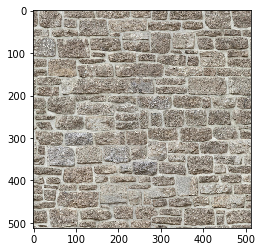

In [102]:
obj = ObjLoader()
obj.load_model("models/wall.obj")
img = obj.material.getKdImage()

print(f"vert_coords ({len(obj.vert_coords)})   = {obj.vert_coords}")
print(f"text_coords ({len(obj.text_coords)})   = {obj.text_coords}")
print(f"norm_coords ({len(obj.norm_coords)})   = {obj.norm_coords}")
print(f"vert_colors ({len(obj.vert_colors)})   = {obj.vert_colors}")
print(f"vertex_index ({len(obj.vertex_index)})  = {obj.vertex_index}")
print(f"texture_index ({len(obj.texture_index)}) = {obj.texture_index}")
print(f"normal_index ({len(obj.normal_index)})  = {obj.normal_index}")

texture_rgba = img.convert('RGBA')
plt.imshow(texture_rgba)
plt.show()

In [103]:
obj.print_model()

(min_x, min_y, min_z), (max_x, max_y, max_z) = obj.calc_boundaries()

print(min_x, min_y, min_z)
print(max_x, max_y, max_z)

0.0 0.0 0.0
1.0 2.0 1.0


mtllib wall.mtl
o Cube
v 1.000000 0.000000 0.000000
v 1.000000 0.000000 1.000000
v 0.000000 0.000000 1.000000
v 0.000000 0.000000 0.000000
v 1.000000 2.000000 0.000000
v 1.000000 2.000000 1.000000
v 0.000000 2.000000 1.000000
v 0.000000 2.000000 0.000000
vt 0.0000 0.0000
vt 0.0000 1.0000
vt 1.0000 1.0000
vt 1.0000 0.0000
vt 0.0000 0.0000
vt 0.0000 1.0000
vt 1.0000 1.0000
vt 1.0000 0.0000
vt 0.0000 1.0000
vt 1.0000 1.0000
vt 1.0000 0.0000
vt 0.0000 0.0000
vt 0.0000 1.0000
vt 1.0000 0.0000
vt 0.0000 0.0000
vt 0.0000 1.0000
vt 1.0000 1.0000
vt 0.0000 1.0000
vt 1.0000 1.0000
vt 1.0000 0.0000
vn 0.0000 -1.0000 0.0000
vn 0.0000 1.0000 0.0000
vn 1.0000 0.0000 0.0000
vn -0.0000 -0.0000 1.0000
vn -1.0000 -0.0000 -0.0000
vn 0.0000 0.0000 -1.0000
usemtl Material
s off
f 1/1/1 2/2/1 3/3/1 4/4/1
f 5/5/2 8/6/2 7/7/2 6/8/2
f 1/1/3 5/9/3 6/10/3 2/11/3
f 2/12/4 6/13/4 7/7/4 3/14/4
f 3/15/5 7/16/5 8/17/5 4/4/5
f 5/5/6 1/18/6 4/19/6 8/20/6


In [104]:
obj = ObjLoader()
obj.load_model("models/column.obj")

(min_x, min_y, min_z), (max_x, max_y, max_z) = obj.calc_boundaries()
dif_x = max_x - min_x
dif_y = max_y - min_y
dif_z = max_z - min_z

print(min_x, min_y, min_z)
print(max_x, max_y, max_z)
print(dif_x, dif_y, dif_z)
 
for v in obj.vert_coords:
    v[0] = (v[0] - min_x) * 1.0 / dif_x
    v[1] = (v[1] - min_y) * 2.0 / dif_y
    v[2] = (v[2] - min_z) * 1.0 / dif_z

(min_x, min_y, min_z), (max_x, max_y, max_z) = obj.calc_boundaries()
print(min_x, min_y, min_z)
print(max_x, max_y, max_z)

0.055098075 -0.037811975 0.058078307
10.89141808 36.25881726 10.89439831
10.836320005 36.296629235 10.836320002999999
0.0 0.0 0.0
1.0 2.0 1.0


In [105]:
obj.print_model()

mtllib column.mtl
o column
v 0.394064 0.048181 0.175847
v 0.406170 1.858276 0.250902
v 0.411404 1.858276 0.228911
v 0.387787 0.048181 0.202143
v 0.383064 1.858276 0.270504
v 0.360192 0.048181 0.225581
v 0.353660 1.858276 0.277664
v 0.325000 0.048181 0.234143
v 0.332787 1.858276 0.268996
v 0.300043 0.048181 0.223777
v 0.332404 1.858276 0.269249
v 0.299596 0.048181 0.224081
v 0.331979 1.858276 0.269555
v 0.299085 0.048181 0.224447
v 0.333787 1.858276 0.292092
v 0.301234 0.048181 0.251396
v 0.317872 1.858276 0.317869
v 0.282234 0.048181 0.282219
v 0.292234 1.858276 0.333732
v 0.251574 0.048181 0.301187
v 0.269745 1.858276 0.332083
v 0.224681 0.048181 0.299215
v 0.269447 1.858276 0.332447
v 0.224319 0.048181 0.299650
v 0.269128 1.858276 0.332873
v 0.223936 0.048181 0.300160
v 0.277681 1.858276 0.353751
v 0.234149 0.048181 0.325125
v 0.270511 1.858276 0.383061
v 0.225596 0.048181 0.360172
v 0.251043 1.858276 0.406059
v 0.202319 0.048181 0.387672
v 0.229170 1.858276 0.411462
v 0.176149 0.048

f 302/121/302 316/262/316 300/101/300
f 303/240/303 304/241/304 301/228/301
f 303/240/303 306/247/306 304/241/304
f 303/140/303 309/201/309 305/161/305
f 304/140/304 310/201/310 302/121/302
f 305/246/305 306/247/306 303/240/303
f 305/246/305 308/257/308 306/247/306
f 305/161/305 309/201/309 307/180/307
f 306/161/306 310/201/310 304/140/304
f 307/256/307 308/257/308 305/246/305
f 307/256/307 310/265/310 308/257/308
f 308/180/308 310/201/310 306/161/306
f 309/264/309 310/265/310 307/256/307
f 309/264/309 312/269/312 310/265/310
f 310/201/310 312/222/312 302/121/302
f 311/268/311 312/269/312 309/264/309
f 311/268/311 314/280/314 312/269/312
f 312/222/312 314/243/314 302/121/302
f 313/279/313 314/280/314 311/268/311
f 313/279/313 316/284/316 314/280/314
f 314/243/314 316/262/316 302/121/302
f 315/283/315 316/284/316 313/279/313
f 315/283/315 318/300/318 316/284/316
f 316/262/316 318/281/318 298/82/298
f 317/299/317 318/300/318 315/283/315
f 317/299/317 320/313/320 318/300/318
f 318/281/318